In [50]:
#Importing packages 
import pandas as pd
import numpy as np
import scipy 
from tqdm import tqdm  #This is for creating progress bars.
import json #To save files in json format
import os #To set working directory
from datetime import datetime #To check start and end time when running code
import pickle  #To store and open previously saved machine learning models 

#Packages for language processing
import re
from collections import defaultdict
import string
import nltk

#Packages for visualization
import seaborn as sns
import matplotlib.pyplot as plt


# Advanced Social Data Science 2 (ASDS2) Exercises


## April 28: Scaling

In this and the next two exercise labs, we will be working with a dataset of tweets from USA Members of Congress. The version of the dataset used today includes the 3000 most recent tweets from each member of congress. We have created a subset of this dataset containing tweets from 2018 and later, to capture only fairly recent tweets as the dataset is very large. 

Preprocessing such a large dataset takes a while to run (approx 20 mins). To save you time and effort, we have uploaded a preprocessed version of the dataset: 'MOC2021_Tweets_2018subset_preprocessed.csv'. 

However, if you have time and wish to replicate the preprocessing yourself, the following steps were applied: 

1. Subsetting dataset to include only tweets from 2018 and later
1. Removing duplicated tweets 
2. Removing unneeded columns (all except 'nominate_name','affiliation','role','nominate_score', and 'text')
3. Turning independents into Democrats or Republicans. In essence, finding the independents ("SANDERS, Bernard" and "KING, Angus Stanley, Jr.") and turning these to "Democrat". 
4. Replace "&" with "and"
5. Remove odd special characters ("┻","┃","━","┳","┓","┏","┛","┗")
6. There are some annoying cases in these data where a character that looks like a space is not a space. Here, we just replace that character with an actual space. Note that the first "space" is not actually a space. " " == " " is FALSE. Replace "\u202F", "\u2069", "\u200d", and "\u2066" with " ".
7. Removing "RT" and "via"
8. Removing mentions (@someone)
9. Removing numbers, removing punctuation (except hyphens), removing separators, removing urls, lowercasing, removing stopwords, and lemmatizing.

### 1: Formatting the dataset to a shape accepted by the scaler

Import the dataset with preprocessed text 'MOC2021_Tweets_2018subset_preprocessed.csv'.

The dataset includes the name of each member of Congress (nominate_name), their affiliation (Democrat or Republican), their institutional role in Congress (House or Senate), their ideological score based on how they vote in Congress (nominate_score) and the text of each of their most recent 3000 tweets, reaching back until the beginning of 2018, in original and preprocessed format. 

1. The goal of our wordfish scaling today is to give each politician an ideological score based on their tweets. To prepare the data, we therefore need to aggregate all text per politician. In essence, transform the dataframe so that each row has one politician (rather than one tweet) and each text field includes all tweets from this politician in one long string. 

Hint for 1.1: When preprocessing, some tweet text was removed (e.g. if they were only URLs). To aggregate text, you may need to replace NaN values with an empty string. Next, the pandas functions `groupby` and `agg` can help you.


2. The wordfish scaler accepts data in the shape of a list of tuples containing the document name and the document text. Essentially that means that you should create a list in the format: [(politician1, preprocessed_text1), (politician2, preprocessed_text2), (politician3, preprocessed_text3)].


In [52]:
#When importing the data, use pd.read_csv('filename', compression = 'bz2')
df = pd.read_csv('/Users/kajsarosenblad/Documents/SODAS/Advanced Data Science 2/week 2/MOC2021_Tweets_2018subset_preprocessed.csv.bz2', compression = 'bz2')


In [ ]:
df.head()

In [53]:
#replace nan with empty string
df['text_preprocessed'] = df['text_preprocessed'].replace(np.nan, '', regex=True)


In [54]:
#transform the dataframe so that each row has one politician (rather than one tweet) and each text field 
#includes all tweets from this politician in one long string.
group_df = df.groupby(['nominate_name','affiliation', 'role', 'nominate_score'])['text_preprocessed'].agg(','.join).reset_index()

In [55]:
group_df.head()

,nominate_name,affiliation,role,nominate_score,text_preprocessed
0,"ADAMS, Alma",Democrat,House,-0.466,"morning conversation holiday,john lewis fighte..."
1,"ADERHOLT, Robert",Republican,House,0.370,",folks pelosi admit impeachment last forever d..."
2,"AGUILAR, Peter Rey",Democrat,House,-0.292,brave inland empire resident answer call serve...
3,"ALLEN, Rick W.",Republican,House,0.680,congratulation gas mr harold quarterman lead c...
4,"ALLRED, Colin",Democrat,House,-0.437,im always impressed local organization communi...


In [57]:
#make list of tuples with names and text
tuple_list = []

for row in group_df.iterrows():
    tup = (row[1].nominate_name,row[1].text_preprocessed)
    tuple_list.append(tup)
    
    

### 2: Scaling with Wordfish

The wordfish scaler we are using is from the implementation found here: https://github.com/umanlp/SemScale. 

As this is not a (super) professional implementation, there is almost no documentation of how to use the code. Therefore, we have copied the essential parts of their `wordfish.py` code below and ask you to fill in the blanks with data from the list you have just created. 

You can check what the object `corp` contains with the following commands: 
- `corp.occurences`: See the document-feature matrix 
- `corp.vocubulary`: See the full vocabulary across documents. Numbers indicate their index in the dfm. 
- `corp.results`: See the scaling results 

The wordfish scaler takes several hours to run on the full dataset. Select a **subset of perhaps 20 politicians** to check that you have a code that works. 

#### Importing code 

Download the code from the github repository and store it somewhere on your computer. The following imports will be drawing on code in that folder. 

In [58]:
#Setting working directory to be where the SemScale code is stored 
path = '/Users/kajsarosenblad/Documents/SODAS/Advanced Data Science 2/week 2/SemScale-master' #Insert the path to where you have stored the SemScale-master folder as a string
os.chdir(path)

#Scaling packages 
from helpers import io_helper
from wfcode import corpus
from wfcode import scaler
import argparse


#### Creating a corpus object

In [59]:
#Select a subset of your list of politicians 
subset = tuple_list[10:30]


In [60]:
#Setting parameters (keeping the default parameters as used in the github code)

niter = 5000      #number of iterations
lr = 0.00001      #learning rate
stopwords = None  #we've already removed stopwords


In [61]:
#Creating a corpus object

corp = corpus.Corpus(subset) #input your subsetted data in the parentheses

Loading corpus, received: 20 docs.


In [62]:
#Run this code with no alterations

#Preprocessing data
corp.tokenize(stopwords = stopwords, freq_treshold = 2)

#Building the document-feature matrix
corp.build_occurrences()

2021-04-28 10:59:43 Preprocessing corpus...
2021-04-28 10:59:49 Building vocabulary...
2021-04-28 10:59:50 Building coocurrence matrix...
1/20
2/20
3/20
4/20
5/20
6/20
7/20
8/20
9/20
10/20
11/20
12/20
13/20
14/20
15/20
16/20
17/20
18/20
19/20
20/20


#### Investigating the corpus object

Check the shape of your document-feature matrix. Check the vocabulary of the corpus.


corp.occurences: See the document-feature matrix
corp.vocubulary: See the full vocabulary across documents. Numbers indicate their index in the dfm.
corp.results: See the scaling results

In [72]:
#Check the shape of the document-feature matrix
corp.occurrences

array([[144.,  35.,   8., ...,   1.,   1.,   1.],
       [198.,  64.,  16., ...,   1.,   1.,   1.],
       [ 24.,   8.,   1., ...,   1.,   1.,   1.],
       ...,
       [ 88.,  42.,  11., ...,   1.,   1.,   1.],
       [ 31.,  13.,   1., ...,   1.,   1.,   1.],
       [273.,  84.,  12., ...,   2.,   2.,   2.]], dtype=float32)

In [82]:
#Check the vocabulary 
vocabulary = corp.vocabulary

#### Training the wordfish scaler

In [74]:
#Run this code with no alterations

wf_scaler = scaler.WordfishScaler(corp)

print(datetime.now().strftime('%Y-%m-%d %H:%M:%S') + " WordFish scaling begun.")

wf_scaler.initialize()
wf_scaler.train(learning_rate = lr, num_iters = niter)

print(datetime.now().strftime('%Y-%m-%d %H:%M:%S') + " WordFish scaling completed.")

2021-04-28 11:02:40 WordFish scaling begun.
Initializing...
Alpha docs: 
[ 0.          0.5811401  -0.4392104   0.05003661  0.45665234  0.28658348
 -0.08026847  0.34255347 -0.07004075 -0.04940938  0.28804514  0.6479377
  0.1067118  -0.3877437   0.42324317  0.30474922 -0.2921803  -0.02932561
 -0.41955262  0.46336913]
Training...
Initial objective score: -1934252.25
Iteration (secondary) 1: -1934320.625
Iteration (secondary) 101: -1940306.5
Iteration (secondary) 201: -1945012.5
Iteration (secondary) 301: -1948879.5
Iteration (secondary) 401: -1952157.875
Iteration (secondary) 501: -1954997.25
Iteration (secondary) 601: -1957499.625
Iteration (secondary) 701: -1959734.5
Iteration (secondary) 801: -1961752.5
Iteration (secondary) 901: -1963591.875
Iteration (secondary) 1001: -1965281.125
Iteration (secondary) 1101: -1966843.125
Iteration (secondary) 1201: -1968296.875
Iteration (secondary) 1301: -1969655.0
Iteration (secondary) 1401: -1970931.375
Iteration (secondary) 1501: -1972133.875
Ite

#### Results 

View the results of the scaler. 

In [75]:
corp.results

{'BABIN, Brian': -0.34607804,
 'BACON, Donald J.': 1.39345,
 'BAIRD, James': -1.6650634,
 'BALDERSON, Troy': -0.17626695,
 'BALDWIN, Tammy': 1.2270474,
 'BANKS, James E.': 0.45003572,
 'BARR, Garland H. (Andy) IV': -0.59714186,
 'BARRAGÁN, Nanette Diaz': 0.6461194,
 'BARRASSO, John A.': -0.5030484,
 'BASS, Karen': -0.45903614,
 'BEATTY, Joyce': 0.53668195,
 'BENNET, Michael F.': 1.6983627,
 'BERA, Ami': 0.05142092,
 'BERGMAN, John': -1.5114324,
 'BEYER, Donald Sternoff Jr.': 0.98153275,
 'BIGGS, Andrew S.': 0.59380734,
 'BILIRAKIS, Gus': -1.2228254,
 'BISHOP, Dan': -0.5200997,
 'BISHOP, Sanford Dixon, Jr.': -1.608001,
 'BLACKBURN, Marsha': 1.0305351}

### 3: Validating and inspecting the results: part 1

Running the wordfish scaler on the full dataset takes several hours. Therefore, we've prepared two models for you pre-trained on the full dataset. Load the models called 'MOCscalingresults.sav' (the corp object) and 'MOCscaler.sav' (the wf_scaler object) from Absalon with the code below.

To make sure we have meaningful results, check the alpha, psi, and beta values. 

1. Beta values can be accessed with `wf_scaler.beta_words`. Find the 10 words that are most predictive of the low end of the ideology scale and the 10 words that are most predictive of the high end of the ideology scale. Based on these words, can you guess which ideology (Democrat vs Republican) is categorized with low values and which with high values?
2. Alpha values can be accessed with `wf_scaler.alpha_docs`. Check the document length of the documents with the highest and lowest alpha. Do the results make sense? 
3. Psi values can be accessed with `wf_scaler.psi_words`. Check the frequency of the words with the highest and lowest psi values. Do the results make sense? 

Hint: All the values are stored in numpy arrays. Numpy has functions for getting the original indices of sorted values, and the index placement of minimum and maximum values, `argsort()`, `argmin()`, and `argmax()`.


In [77]:
#Loading the saved models 

path = '/Users/kajsarosenblad/Documents/SODAS/Advanced Data Science 2/week 2/Wordfish models/' #Input the path to where you stored the two models

corp = pickle.load(open(path+'MOCscalingresults.sav', 'rb'))
wf_scaler = pickle.load(open(path+'MOCscaler.sav', 'rb'))


#### 3.1 Beta β

In [96]:
#sort beta values, get indices 
sorted_beta = wf_scaler.beta_words.argsort()


#make word list of vocuabulary (which I can later access by the )
word_list = list(vocabulary.keys())

for item in sorted_beta[:10]:
    print(word_list[item])
    
print('\n')
    
for item in sorted_beta[-10:]:
    print (word_list[item])

idaho
ksleg
alpolitics
louisiana
taxcutsandjobsact
kansa
taxreform
maine
rancher
alabama


fight
change
justice
crisis
pandemic
must
worker
health
trump
climate


#### 3.2 Alpha α

In [103]:
lowest = wf_scaler.alpha_docs.argmin()
highest = wf_scaler.alpha_docs.argmax()

print(lowest)
print(highest)

364
73


#### 3.3 Psi ψ

In [108]:
low = wf_scaler.psi_words.argmin()
high = wf_scaler.psi_words.argmax()

print(word_list[low])
print(word_list[high])

📫restore
andamp


### 4: Validating and inspecting the results: part 2

1. Create a new column in your dataset and input the scaling results. 
2. To validate our results, run the overall correlation between our scaling results and the provided nominate scores. Visualize the correlation in a scatterplot. How well do our scaling results correlate with the nominate scores?
3. Optional: Separate House and Senate. Run correlations within each institution as above and visualize as a scatterplot. 
3. Separate Democrats and Republicans. Run correlations within each party as above and visualize as a scatterplot. Can the scaling results help us determine ideological positions within each party?
4. Find the ideological score as computed by the wordfish scaler of specific politicians that you know, e.g. Ted Cruz and Bernie Sanders. Do the results make sense? Why might the results not be as we would have expected?
5. Based on nominate and scaling scores, respectively, who is the most extremist Republican and the most extremist Democrat? Who is the most left-wing Republican and the most right-wing Democrat? 

Finally, as a reflection exercise, consider the results. What are the limitations of this analysis? Could this be used in a paper or would you need to implement other methods? How could you engineer features of the text to improve the results? 

#### 4.1 Merging scaling results with dataframe

In [110]:
group_df.head()

,nominate_name,affiliation,role,nominate_score,text_preprocessed
0,"ADAMS, Alma",Democrat,House,-0.466,"morning conversation holiday,john lewis fighte..."
1,"ADERHOLT, Robert",Republican,House,0.370,",folks pelosi admit impeachment last forever d..."
2,"AGUILAR, Peter Rey",Democrat,House,-0.292,brave inland empire resident answer call serve...
3,"ALLEN, Rick W.",Republican,House,0.680,congratulation gas mr harold quarterman lead c...
4,"ALLRED, Colin",Democrat,House,-0.437,im always impressed local organization communi...


In [115]:
group_df['scale'] = list(corp.results.values())

In [116]:
group_df.head()

,nominate_name,affiliation,role,nominate_score,text_preprocessed,scale
0,"ADAMS, Alma",Democrat,House,-0.466,"morning conversation holiday,john lewis fighte...",0.534730
1,"ADERHOLT, Robert",Republican,House,0.370,",folks pelosi admit impeachment last forever d...",-1.299027
2,"AGUILAR, Peter Rey",Democrat,House,-0.292,brave inland empire resident answer call serve...,-1.366026
3,"ALLEN, Rick W.",Republican,House,0.680,congratulation gas mr harold quarterman lead c...,-0.993981
4,"ALLRED, Colin",Democrat,House,-0.437,im always impressed local organization communi...,1.044813


#### 4.2 Overall correlation between our scaling results and the provided nominate scores

Nominate' vs. Scale: 	corr -0.5018179855789535, 	p-value 3.0015710078757034e-33


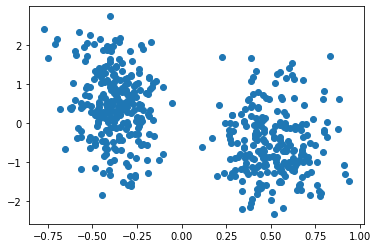

In [120]:
r, p = scipy.stats.pearsonr(group_df['nominate_score'], group_df['scale'])
print("Nominate' vs. Scale: \tcorr {}, \tp-value {}".format(r,p))

plt.scatter(group_df['nominate_score'], group_df['scale'])
plt.show()

#### 4.3 Optional: Correlations within the Senate and House, respectively

#### 4.4 Correlations within the two parties

Republican correlation: 	corr -0.03111231300266385, 	p-value 0.6358615580309996
Democrat correlation: 	corr -0.16653139140279705, 	p-value 0.006483145270700463


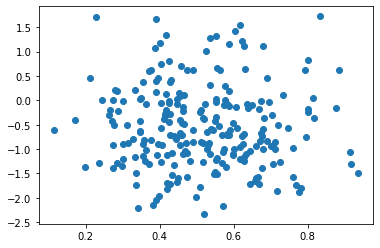

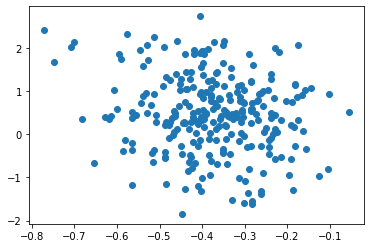

In [131]:
#separate in parties 
rep = group_df[group_df['affiliation'] == 'Republican']
dem = group_df[group_df['affiliation'] == 'Democrat']

#correlations for both parties
r, p = scipy.stats.pearsonr(rep['nominate_score'], rep['scale'])
print("Republican correlation: \tcorr {}, \tp-value {}".format(r,p))

r, p = scipy.stats.pearsonr(dem['nominate_score'], dem['scale'])
print("Democrat correlation: \tcorr {}, \tp-value {}".format(r,p))

#plots for both parties
plt.scatter(rep['nominate_score'], rep['scale'])

plt.show()

plt.scatter(dem['nominate_score'], dem['scale'])

#### 4.5 Scores for specific politicians

In [140]:
bernie = group_df[group_df['nominate_name'] == 'SANDERS, Bernard']
cruz = group_df[group_df['nominate_name'] == 'CRUZ, Rafael Edward (Ted)']

print(bernie.scale)
print(cruz.scale)

393    2.058604
Name: scale, dtype: float64
106    1.7237
Name: scale, dtype: float64


#### 4.6.1 Most extreme Republican and Democrat

In [160]:
#scale extremes


print('Most extreme republican (scale): ', rep[rep['scale'] == rep['scale'].max()].nominate_name)

print('Least extreme republican (scale): ', rep[rep['scale'] == rep['scale'].min()].nominate_name)



print('Least extreme democrat (scale): ', dem[dem['scale'] == dem['scale'].min()].nominate_name)

print('Most extreme democrat (scale): ', dem[dem['scale'] == dem['scale'].max()].nominate_name)

Most extreme republican (scale):  106    CRUZ, Rafael Edward (Ted)
Name: nominate_name, dtype: object
Least extreme republican (scale):  364    POSEY, Bill
Name: nominate_name, dtype: object
Least extreme democrat (scale):  303    MFUME, Kweisi
Name: nominate_name, dtype: object
Most extreme democrat (scale):  73    CASTEN, Sean
Name: nominate_name, dtype: object


#### 4.6.2 Most left-wing Republican and most right-wing Democrat

In [157]:
#nominate extremes
print('Max score, republican: ', rep[rep['nominate_score']==rep['nominate_score'].max()].nominate_name)

print('Min score, republican: ', rep[rep['nominate_score']==rep['nominate_score'].min()].nominate_name)


print('Max score, democrat: ', dem[dem['nominate_score']==dem['nominate_score'].max()].nominate_name)

print('Min score, democrat: ', dem[dem['nominate_score']==dem['nominate_score'].min()].nominate_name)


Max score, republican:  198    HERRELL, Yvette
Name: nominate_name, dtype: object
Min score, republican:  88    COLLINS, Susan Margaret
Name: nominate_name, dtype: object
Max score, democrat:  289    MANCHIN, Joe, III
Name: nominate_name, dtype: object
Min score, democrat:  476    WARREN, Elizabeth
Name: nominate_name, dtype: object
